In [5]:
using LinearAlgebra
using Distributions 
using Random
using Plots

1. Generate some data $(\mathbf{X}, \vec{y})$ to fit our Gaussian process to. 

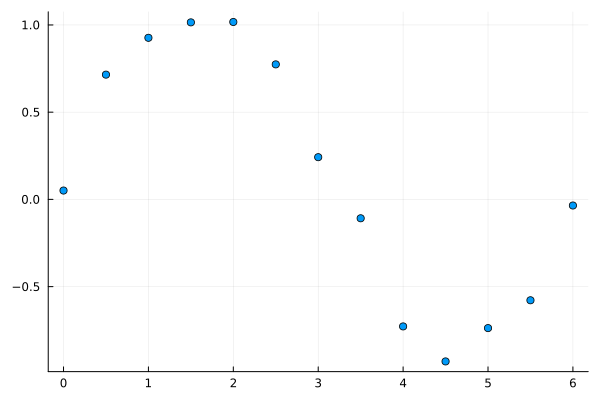

In [292]:
# function to sample from: 

σₙ² = 0.25
σf² = 1
ℓ= 1

y(x) = sin(x) + σₙ²*rand()

X = 0:0.5:2π
y⃗ = y.(X)
X = X'


plot(X', y⃗, seriestype=:scatter, label="")

2. Compute Kernel matrix on sample data. We will use RBF kernel given by 
\begin{equation}
k(\vec{x},\vec{x}') = \sigma_f^2 \exp\left(-\frac{1}{2\ell^2}(\vec{x}-\vec{x}')^2\right) + \sigma_n^2 \delta_{\vec{x},\vec{x}'}
\end{equation}

In [293]:
# first define how copute elemnt i,j 
function rbf_ij(X₁::AbstractMatrix, X₂::AbstractMatrix, i::Int, j::Int)
    return σf²*exp(-(X₁[:,i] .- X₂[:,j])' * (X₁[:,i] .- X₂[:,j])/(2ℓ^2))
end

rbf_ij(X,X, 1, 2)

0.8824969025845955

In [294]:
function RBF(X₁::AbstractMatrix, X₂::AbstractMatrix)
    (d₁,n₁) = size(X₁)
    (d₂,n₂) = size(X₂)
    # we need to require d₁ == d₂
    K = zeros(n₁, n₂)
 
    @inline for j ∈ 1:n₂, i ∈ 1:n₁
        K[i,j] = rbf_ij(X₁, X₂, i, j)
    end
    
    return K 
end

K = RBF(X,X) + σₙ²*I

13×13 Matrix{Float64}:
 1.25         0.882497     0.606531     …  2.69958e-7   1.523e-8
 0.882497     1.25         0.882497        3.72665e-6   2.69958e-7
 0.606531     0.882497     1.25            4.00653e-5   3.72665e-6
 0.324652     0.606531     0.882497        0.000335463  4.00653e-5
 0.135335     0.324652     0.606531        0.00218749   0.000335463
 0.0439369    0.135335     0.324652     …  0.011109     0.00218749
 0.011109     0.0439369    0.135335        0.0439369    0.011109
 0.00218749   0.011109     0.0439369       0.135335     0.0439369
 0.000335463  0.00218749   0.011109        0.324652     0.135335
 4.00653e-5   0.000335463  0.00218749      0.606531     0.324652
 3.72665e-6   4.00653e-5   0.000335463  …  0.882497     0.606531
 2.69958e-7   3.72665e-6   4.00653e-5      1.25         0.882497
 1.523e-8     2.69958e-7   3.72665e-6      0.882497     1.25

In [295]:
is = 1:3
js = 1:5 

res = [i == j for i ∈ is, j ∈ js]

3×5 Matrix{Bool}:
 1  0  0  0  0
 0  1  0  0  0
 0  0  1  0  0

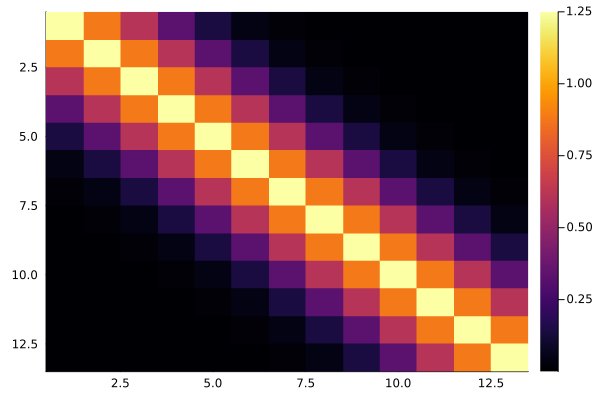

In [296]:
# visualize the covariance matrix
# heatmap(log10.(K), yflip=true)
heatmap(K, yflip=true)

In [297]:
L = cholesky(K).L

13×13 LowerTriangular{Float64, Matrix{Float64}}:
 1.11803       ⋅            ⋅           …   ⋅         ⋅         ⋅ 
 0.789329     0.791808      ⋅               ⋅         ⋅         ⋅ 
 0.542498     0.573735     0.791533         ⋅         ⋅         ⋅ 
 0.290378     0.476538     0.570489         ⋅         ⋅         ⋅ 
 0.121048     0.289346     0.473581         ⋅         ⋅         ⋅ 
 0.0392984    0.131744     0.287729     …   ⋅         ⋅         ⋅ 
 0.00993619   0.0455843    0.131127         ⋅         ⋅         ⋅ 
 0.00195655   0.0120795    0.045412         ⋅         ⋅         ⋅ 
 0.000300047  0.00246355   0.0120435        ⋅         ⋅         ⋅ 
 3.58355e-5   0.000387943  0.00245786       ⋅         ⋅         ⋅ 
 3.33322e-6   4.7277e-5    0.000387261  …  0.782018   ⋅         ⋅ 
 2.41458e-7   4.46581e-6   4.72148e-5      0.560661  0.782017   ⋅ 
 1.36221e-8   3.27359e-7   4.46153e-6      0.470599  0.560661  0.782017

In [298]:
# compute expansion coefficients
α⃗ = (L')\(L\y⃗)
size(α⃗)

(13,)

In [299]:
# now we need a function to compue mean 
Xnew = (0:0.05:2π)'
Koldnew = RBF(X, Xnew)
y⃗new = Koldnew'*α⃗

126-element Vector{Float64}:
  0.2080861718476807
  0.23992151099092268
  0.2727088664398219
  0.30631162364348985
  0.34058526764858965
  0.37537873560929774
  0.4105358397987505
  0.4458967371541492
  0.48129942065075587
  0.5165812076209636
  0.5515802005169567
  0.5861366965473367
  0.6200945240723865
  ⋮
 -0.33180994435221944
 -0.30024214681690936
 -0.2692239585931777
 -0.23890153836389255
 -0.209410788366817
 -0.18087655023198249
 -0.15341192279859595
 -0.1271177079932637
 -0.1020819892581364
 -0.07837984533341569
 -0.05607320044923437
 -0.03521081019587117

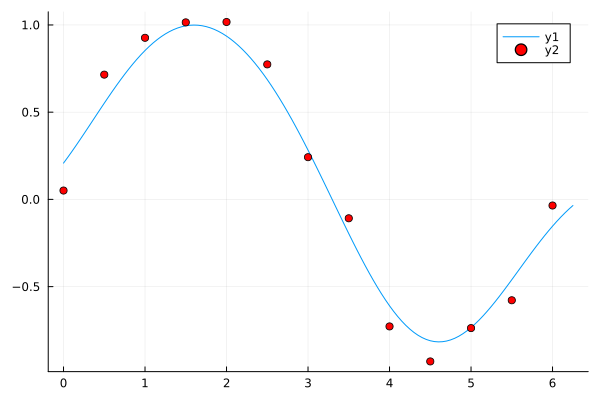

In [300]:
plot(Xnew', y⃗new)
plot!(X', y⃗, seriestype=:scatter, color=:red)